In [1]:
import pandas as pd
import tensorflow
import numpy as np
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.applications import MobileNetV2

In [2]:
base_model=MobileNetV2(include_top=False, weights="imagenet", input_shape=(224,224,3))

In [3]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='sigmoid'))


In [4]:
data=pd.read_csv('data/HAM10000/HAM10000_metadata.csv')
data['image_full_name']=data['image_id']+'.jpg'
X=data[['image_full_name','dx','lesion_id']]

In [5]:
X.sample(5)

,image_full_name,dx,lesion_id
6307,ISIC_0032495.jpg,nv,HAM_0004770
6759,ISIC_0032209.jpg,nv,HAM_0001100
7436,ISIC_0032795.jpg,nv,HAM_0005961
9246,ISIC_0029498.jpg,nv,HAM_0001356
4220,ISIC_0029449.jpg,nv,HAM_0000957


In [6]:
from sklearn.model_selection import train_test_split
Y=X.pop('dx').to_frame()
X_train, X_test, y_train, y_test   = train_test_split(X,Y, test_size=0.17, random_state=42)
X_train,X_val,y_train,y_val        =train_test_split(X_train, y_train, test_size=0.17, random_state=42)

In [7]:
train=pd.concat([X_train,y_train],axis=1)
val=pd.concat([X_val,y_val],axis=1)
test=pd.concat([X_test,y_test],axis=1)

In [8]:
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_train=encoder.transform(val['dx']) 
val['label']=name_as_indexes_train

In [9]:
encoder=LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test=encoder.transform(test['dx']) 
test['label']=name_as_indexes_test

In [10]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=10,  
                                     zoom_range = 0.1, 
                                     width_shift_range=0.0,  height_shift_range=0.00) 

In [11]:
train_data= train_generator.flow_from_dataframe(dataframe=train,x_col="image_full_name",y_col="dx",
                                                batch_size=32,directory="data/all_images",
                                                shuffle=True,class_mode="categorical",target_size=(224,224))

Found 6898 validated image filenames belonging to 7 classes.


In [12]:
test_generator=ImageDataGenerator(rescale = 1./255,rotation_range=10,  
                                     zoom_range = 0.1, 
                                     width_shift_range=0.0,  height_shift_range=0.02)

In [13]:
test_data= test_generator.flow_from_dataframe(dataframe=test,x_col="image_full_name",y_col="dx",
                                              directory="data/all_images/",
                                              shuffle=False,batch_size=1,class_mode=None,target_size=(224,224))


Found 1703 validated image filenames.


In [14]:
val_data=test_generator.flow_from_dataframe(dataframe=val,x_col="image_full_name",y_col="dx",
                                            directory="data/all_images/",
                                            batch_size=64,shuffle=False,class_mode="categorical",target_size=(224,224))

Found 1414 validated image filenames belonging to 7 classes.


In [15]:
from keras.callbacks import ReduceLROnPlateau
learning_control = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=.5, min_lr=0.0001)

In [16]:
from keras.optimizers import Adam,SGD
sgd = optimizers.SGD(lr = 0.01, clipvalue = 0.5)
model.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=["accuracy"])

In [17]:
history = model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            epochs=30,callbacks=[learning_control])

C:\Users\Rasti fitness\AppData\Local\Temp\ipykernel_9072\1443149548.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_data,


Epoch 1/30



215/215 [==============================] - ETA: 0s - loss: 1.0995 - accuracy: 0.6572WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 606s 3s/step - loss: 1.0995 - accuracy: 0.6572 - val_loss: 1.3320 - val_accuracy: 0.6683 - lr: 0.0100
Epoch 2/30
215/215 [==============================] - ETA: 0s - loss: 0.8572 - accuracy: 0.6952WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 520s 2s/step - loss: 0.8572 - accuracy: 0.6952 - val_loss: 2.1374 - val_accuracy: 0.6733 - lr: 0.0100
Epoch 3/30
215/215 [==============================] - ETA: 0s - loss: 0.7475 - accuracy: 0.7281WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 515s 2s/step - loss: 0.7475 - accuracy: 0.7281 - val_loss: 2.1100 - val_accuracy: 0.6726 - lr: 0.0100
Epoch 4/30
215/215 [==============================] - ETA: 0s - loss: 0.6895 - accuracy: 0.7540WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 527s 2s/step - loss: 0.6895 - accuracy: 0.7540 - val_loss: 1.3710 - val_accuracy: 0.6783 - lr: 0.0100
Epoch 5/30
215/215 [==============================] - ETA: 0s - loss: 0.6270 - accuracy: 0.7782WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 519s 2s/step - loss: 0.6270 - accuracy: 0.7782 - val_loss: 1.0919 - val_accuracy: 0.6804 - lr: 0.0100
Epoch 6/30
215/215 [==============================] - ETA: 0s - loss: 0.5656 - accuracy: 0.8003WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 517s 2s/step - loss: 0.5656 - accuracy: 0.8003 - val_loss: 1.1277 - val_accuracy: 0.6939 - lr: 0.0100
Epoch 7/30
215/215 [==============================] - ETA: 0s - loss: 0.5177 - accuracy: 0.8149WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 518s 2s/step - loss: 0.5177 - accuracy: 0.8149 - val_loss: 1.2187 - val_accuracy: 0.7088 - lr: 0.0100
Epoch 8/30
215/215 [==============================] - ETA: 0s - loss: 0.4736 - accuracy: 0.8293WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 523s 2s/step - loss: 0.4736 - accuracy: 0.8293 - val_loss: 1.4792 - val_accuracy: 0.6953 - lr: 0.0100
Epoch 9/30
215/215 [==============================] - ETA: 0s - loss: 0.4387 - accuracy: 0.8439WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 516s 2s/step - loss: 0.4387 - accuracy: 0.8439 - val_loss: 0.8446 - val_accuracy: 0.7266 - lr: 0.0100
Epoch 10/30
215/215 [==============================] - ETA: 0s - loss: 0.3968 - accuracy: 0.8653WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 529s 2s/step - loss: 0.3968 - accuracy: 0.8653 - val_loss: 1.7161 - val_accuracy: 0.7173 - lr: 0.0100
Epoch 11/30
215/215 [==============================] - ETA: 0s - loss: 0.3613 - accuracy: 0.8781WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 520s 2s/step - loss: 0.3613 - accuracy: 0.8781 - val_loss: 2.1178 - val_accuracy: 0.7287 - lr: 0.0100
Epoch 12/30
215/215 [==============================] - ETA: 0s - loss: 0.3256 - accuracy: 0.8845WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 520s 2s/step - loss: 0.3256 - accuracy: 0.8845 - val_loss: 1.2926 - val_accuracy: 0.7486 - lr: 0.0100
Epoch 13/30
215/215 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.8908WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 503s 2s/step - loss: 0.3138 - accuracy: 0.8908 - val_loss: 0.8451 - val_accuracy: 0.7940 - lr: 0.0100
Epoch 14/30
215/215 [==============================] - ETA: 0s - loss: 0.2542 - accuracy: 0.9142WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 499s 2s/step - loss: 0.2542 - accuracy: 0.9142 - val_loss: 2.9489 - val_accuracy: 0.3530 - lr: 0.0100
Epoch 15/30
215/215 [==============================] - ETA: 0s - loss: 0.2439 - accuracy: 0.9128WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 486s 2s/step - loss: 0.2439 - accuracy: 0.9128 - val_loss: 2.6676 - val_accuracy: 0.3928 - lr: 0.0100
Epoch 16/30
215/215 [==============================] - ETA: 0s - loss: 0.2314 - accuracy: 0.9206WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 528s 2s/step - loss: 0.2314 - accuracy: 0.9206 - val_loss: 0.6711 - val_accuracy: 0.7862 - lr: 0.0100
Epoch 17/30
215/215 [==============================] - ETA: 0s - loss: 0.2066 - accuracy: 0.9307WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 531s 2s/step - loss: 0.2066 - accuracy: 0.9307 - val_loss: 0.6972 - val_accuracy: 0.7876 - lr: 0.0100
Epoch 18/30
215/215 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.9331WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 496s 2s/step - loss: 0.1913 - accuracy: 0.9331 - val_loss: 0.7704 - val_accuracy: 0.8004 - lr: 0.0100
Epoch 19/30
215/215 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.9404WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 481s 2s/step - loss: 0.1752 - accuracy: 0.9404 - val_loss: 0.9672 - val_accuracy: 0.7983 - lr: 0.0100
Epoch 20/30
215/215 [==============================] - ETA: 0s - loss: 0.1593 - accuracy: 0.9490WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 497s 2s/step - loss: 0.1593 - accuracy: 0.9490 - val_loss: 0.6554 - val_accuracy: 0.8004 - lr: 0.0100
Epoch 21/30
215/215 [==============================] - ETA: 0s - loss: 0.1485 - accuracy: 0.9505WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 477s 2s/step - loss: 0.1485 - accuracy: 0.9505 - val_loss: 1.2322 - val_accuracy: 0.6847 - lr: 0.0100
Epoch 22/30
215/215 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.9554WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 476s 2s/step - loss: 0.1326 - accuracy: 0.9554 - val_loss: 0.8128 - val_accuracy: 0.7976 - lr: 0.0100
Epoch 23/30
215/215 [==============================] - ETA: 0s - loss: 0.1290 - accuracy: 0.9598WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 492s 2s/step - loss: 0.1290 - accuracy: 0.9598 - val_loss: 0.8306 - val_accuracy: 0.7997 - lr: 0.0100
Epoch 24/30
215/215 [==============================] - ETA: 0s - loss: 0.1401 - accuracy: 0.9541WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 492s 2s/step - loss: 0.1401 - accuracy: 0.9541 - val_loss: 0.8811 - val_accuracy: 0.8175 - lr: 0.0100
Epoch 25/30
215/215 [==============================] - ETA: 0s - loss: 0.0829 - accuracy: 0.9747WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 514s 2s/step - loss: 0.0829 - accuracy: 0.9747 - val_loss: 1.0562 - val_accuracy: 0.8033 - lr: 0.0100
Epoch 26/30
215/215 [==============================] - ETA: 0s - loss: 0.1098 - accuracy: 0.9674WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 513s 2s/step - loss: 0.1098 - accuracy: 0.9674 - val_loss: 1.7716 - val_accuracy: 0.5874 - lr: 0.0100
Epoch 27/30
215/215 [==============================] - ETA: 0s - loss: 0.1032 - accuracy: 0.9680WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 503s 2s/step - loss: 0.1032 - accuracy: 0.9680 - val_loss: 1.6997 - val_accuracy: 0.7024 - lr: 0.0100
Epoch 28/30
215/215 [==============================] - ETA: 0s - loss: 0.0971 - accuracy: 0.9690WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 492s 2s/step - loss: 0.0971 - accuracy: 0.9690 - val_loss: 1.6415 - val_accuracy: 0.7798 - lr: 0.0100
Epoch 29/30
215/215 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9764WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 475s 2s/step - loss: 0.0727 - accuracy: 0.9764 - val_loss: 0.8968 - val_accuracy: 0.8104 - lr: 0.0100
Epoch 30/30
215/215 [==============================] - ETA: 0s - loss: 0.0633 - accuracy: 0.9806WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 475s 2s/step - loss: 0.0633 - accuracy: 0.9806 - val_loss: 0.9689 - val_accuracy: 0.7905 - lr: 0.0100


In [18]:
model.save('model12345.h5')

C:\Users\Rasti fitness\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


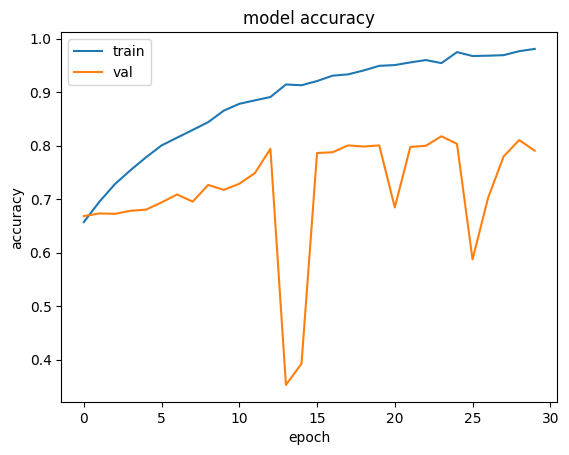

In [23]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


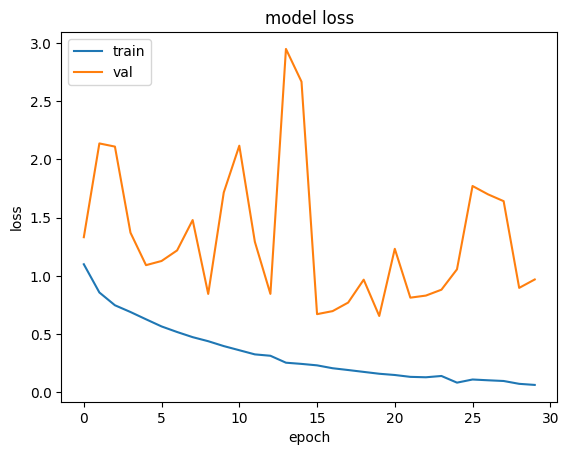

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

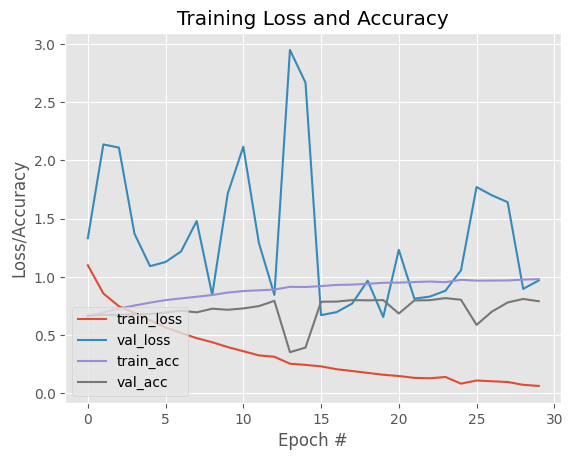

In [28]:
N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


In [29]:
test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

C:\Users\Rasti fitness\AppData\Local\Temp\ipykernel_9072\1044357436.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)


1703/1703 [==============================] - 76s 44ms/step


In [30]:
c=np.where(y_pred == name_as_indexes_test)

In [31]:
np.count_nonzero(c)

1324

In [32]:
print("Test Accuracy :",(np.count_nonzero(c)/len(name_as_indexes_test))*100)

Test Accuracy : 77.74515560775103


In [33]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(name_as_indexes_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.71      0.39      0.50        62
           1       0.78      0.68      0.72        77
           2       0.45      0.85      0.59       201
           3       0.82      0.38      0.51        24
           4       0.52      0.42      0.46       191
           5       0.94      0.86      0.90      1128
           6       0.79      0.95      0.86        20

    accuracy                           0.78      1703
   macro avg       0.71      0.64      0.65      1703
weighted avg       0.81      0.78      0.78      1703



In [34]:
model.save("model12345.h5")

C:\Users\Rasti fitness\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
